### Imports

In [1]:
cd ..

c:\Users\seand\OneDrive\Dokumente\Masterthesis\StarBoundaryNetworks\src


In [2]:
import torch
from torch import nn

from domains.starDomain import Sphere
from domains.timeStarSpaceDomain import *
from pdeOperators.operators import *
from lossFuncitons.pinnLossFunctions import *
from lossFuncitons.pinnNeuralOperatorLoss import *
from neuralOperators.imposedBCNeuralOperator import *
from neuralOperators.classicalNeuralOperators import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from scipy.interpolate import griddata
from ipywidgets import *
import numpy as np

%matplotlib widget

Problem is defined in the following way. Let $\Omega = B(0,1)$ be the open Ball with center at 0 and radius 1.
We want to find the solution of 

_______________________________

$\Delta u(x,t) - \partial_t u(x,t) = 0 , ~ \text{on }   \Omega \times [0,T) $ and 

$ u(x,t) = g(x,t),        ~ \text{on }   (\partial \Omega \times [0,T)) \cup  (\Omega \times \{ 0 \})  $

_______________________________

For $f \in C( (\partial \Omega \times [0,T)) \cup (\Omega \times \{ 0 \}) )$ are our parabolic boundary conditions, i.e. initial condition + dirichlet conditions at each point in time


### Define some evaluation functions for which we know the analytic solution of the equation above

We train and test on the function set 

$\{ \alpha \cdot u_{1, \lambda _1} + \beta \cdot u_{2, \lambda _2} + \gamma \cdot u_{3, \lambda _3} + \zeta \cdot u_{4, \lambda _4} : ~ \alpha , \beta , \gamma, \zeta \in [-2,2], \lambda _i = {1 \over 10} \}%\in \{ 1,...,10 \} \}$

with 

$u_{1, \lambda}(x,y,t) = \exp(- 2 \lambda ^2 t) \sin( \lambda x ) \sin( \lambda y )$

$u_{2, \lambda}(x,y,t) = \exp(- 2 \lambda ^2 t) \sin( \lambda x ) \cos( \lambda y )$

$u_{3, \lambda}(x,y,t) =  \exp(- 2 \lambda ^2 t)\cos( \lambda x ) \sin( \lambda y )$

$u_{4, \lambda}(x,y,t) = \exp(- 2 \lambda ^2 t) \cos( \lambda x ) \cos( \lambda y )$

In [3]:
def testFunc1(x,t, freq):
    out = torch.exp(-2*freq*freq*t)* torch.sin(freq* x[0])* torch.sin(freq* x[1])
    return out.view(-1,1)

def testFunc2(x,t, freq):
    out = torch.exp(-2*freq*freq*t)* torch.sin(freq* x[0])* torch.cos(freq* x[1])
    return out.view(-1,1)

def testFunc3(x,t, freq):
    out = torch.exp(-2*freq*freq*t)* torch.cos(freq* x[0])* torch.sin(freq* x[1])
    return out.view(-1,1)

def testFunc4(x,t, freq):
    out = torch.exp(-2*freq*freq*t)* torch.cos(freq* x[0])* torch.cos(freq* x[1])
    return out.view(-1,1)

def trainFunc(x,t, a,b,c,d, freq1,freq2,freq3,freq4):
    return a*testFunc1(x,t, freq1/10) + b*testFunc2(x,t, freq2/10) + c*testFunc3(x,t, freq3/10)+ d*testFunc4(x,t, freq4/10)

### Set Device

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Generate Domain and Data Points on ball and on boundary

In [6]:
#generate Points for training
domainSpaceOnly  = Sphere(2,torch.tensor([0.,0.]), torch.tensor(1.),device)

spaceTimeDomain = timeStarSpaceDomain(domainSpaceOnly, endTime = torch.tensor(10.), device= device)


spacePoints, timePoints = spaceTimeDomain.generateCartesianRandomPointsFullDomain(3000)
parabolicBoundarySpace, parabolicBoundaryTime = spaceTimeDomain.generateParabolicBoundarySphericalFromCartesian(1000)

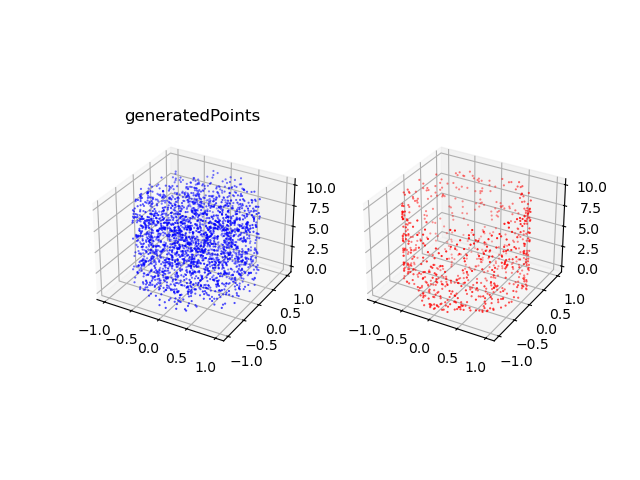

In [7]:
#plot generated points
pointsAsOneTensor = torch.cat((spacePoints[0],spacePoints[1],timePoints ), dim= 1).to("cpu")
boundaryPointsAsOneTensor = torch.cat((parabolicBoundarySpace[0],parabolicBoundarySpace[1],parabolicBoundaryTime ), dim= 1).to("cpu")
fig1 = plt.figure()
ax1 = fig1.add_subplot(121, projection='3d')
ax2 = fig1.add_subplot(122, projection='3d')
ax1.set_title('generatedPoints')
ax1.scatter(pointsAsOneTensor[:,0],pointsAsOneTensor[:,1], pointsAsOneTensor[:,2],s = 0.3, c = "blue")
ax2.scatter(boundaryPointsAsOneTensor[:,0],boundaryPointsAsOneTensor[:,1], boundaryPointsAsOneTensor[:,2],s = 0.3, c = "red")
plt.show()

#### Create Or Load Models:

In [8]:
createNewModel = False

if createNewModel:
    solOperatorImposed = ImposedBCDeepONetSphere2D_ParabDBDCondToSol(    
                                                n_hidden_trunk = 500,
                                                n_layers_trunk = 2,
                                                n_hidden_branch = 500,
                                                n_layers_branch = 2,
                                                spaceTimeDomain = spaceTimeDomain,
                                                nParabBoundaryPoints = 1000
                                                )
else:
    solOperatorImposed = torch.load("./trainedModels/heatImposedDeepONet.pt")


In [9]:
createNewModel = False

if createNewModel:
    solOperatorClassical = DeepONetSphere2D_ParabDBDCondToSol(    
                                    n_hidden_trunk = 500,
                                    n_layers_trunk = 2,
                                    n_hidden_branch = 500,
                                    n_layers_branch = 2,
                                    parabBDPointsSpace = parabolicBoundarySpace,
                                    parabBDPointsTime = parabolicBoundaryTime
                                                    )
else:
    solOperatorClassical = torch.load("./trainedModels/heatClassicalDeepONet.pt")

### Setting for Training

#### Setting for Training Imposed DeepONet

In [10]:
xy_grid = spacePoints
xy_grid[0].requires_grad = True
xy_grid[1].requires_grad = True

t_grid = timePoints
t_grid.requires_grad = True

bdPointsSpace = parabolicBoundarySpace
bdPointsTime = parabolicBoundaryTime
epochs = 1000
learningRate  = 1e-4
boundaryFunctionBatchSize = 20

In [11]:
#move everything to right device
xy_grid[0] = xy_grid[0].to(device)
xy_grid[1] = xy_grid[1].to(device)

t_grid = t_grid.to(device)

bdPointsSpace[0] = bdPointsSpace[0].to(device)
bdPointsSpace[1] = bdPointsSpace[1].to(device)

bdPointsTime = bdPointsTime.to(device)

print()

In [12]:
#define optimizer
optimizerImposed = torch.optim.Adam(solOperatorImposed.parameters(), lr = learningRate)


In [13]:
optimizerClassical = torch.optim.Adam(solOperatorClassical.parameters(), lr = learningRate)

## Training

### Trainig ImposedDeepONet

In [13]:
# move model to device
solOperatorImposed.updateDevice(device)

In [14]:
#computes initial loss to see where we start
loss = heatEquationLossOperator(u = solOperatorImposed, xgrid=xy_grid, tgrid=t_grid, parabolicBoundaryDataFunction = lambda x,t : trainFunc(x,t, 1,1,1,1, 1,1,1,1), device = device )
minLossImposed = loss.item()
minLossImposed

0.7444219917301864

In [15]:
aRand,bRand, cRand, dRand =   torch.rand(4)*4 - 2
lam1Rand, lam2Rand, lam3Rand, lam4Rand = (1,1,1,1)#torch.randint(1,11, (4,))
loss = heatEquationLossOperator(u = solOperatorImposed, xgrid=xy_grid, tgrid=t_grid, parabolicBoundaryDataFunction = lambda x,t : trainFunc(x,t, aRand,bRand, cRand, dRand, lam1Rand, lam2Rand, lam3Rand, lam4Rand), device = device )
minLossImposed = loss.item()
minLossImposed

0.5622855107885706

In [16]:
#training
for i in range(epochs):
    optimizerImposed.zero_grad()
    #add loss of N rdm generated funcitons
    aRand,bRand, cRand, dRand =  torch.rand(4)*4 - 2
    lam1Rand, lam2Rand, lam3Rand, lam4Rand = (1,1,1,1)#torch.randint(1,11, (4,))
    loss = heatEquationLossOperator(u = solOperatorImposed, xgrid=xy_grid, tgrid=t_grid, parabolicBoundaryDataFunction = lambda x,t : trainFunc(x,t, aRand,bRand, cRand, dRand, lam1Rand, lam2Rand, lam3Rand, lam4Rand), device = device )
    for funcIdx in range(boundaryFunctionBatchSize - 1):
        aRand,bRand, cRand, dRand =torch.rand(4)*4 - 2
        lam1Rand, lam2Rand, lam3Rand, lam4Rand = (1,1,1,1)#torch.randint(1,11, (4,))
        loss = loss + heatEquationLossOperator(u = solOperatorImposed, xgrid=xy_grid, tgrid=t_grid, parabolicBoundaryDataFunction = lambda x,t : trainFunc(x,t, aRand,bRand, cRand, dRand, lam1Rand, lam2Rand, lam3Rand, lam4Rand), device = device )
    loss = loss / boundaryFunctionBatchSize
    if loss.item() < minLossImposed:
        minLossImposed = loss.item()
        print("found better model")
        torch.save(solOperatorImposed, "./trainedModels/heatImposedDeepONet.pt")
    if i%1 == 0:
        print(f"epoch {i}")
        print(loss.item())
    loss.backward(retain_graph=True)
    optimizerImposed.step()

epoch 0
0.7780891974080328
epoch 1
0.8017985200530409
epoch 2
0.6023730902057374
found better model
epoch 3
0.21994340678576638
epoch 4
0.3478737364237652
epoch 5
0.36915399554729944
found better model
epoch 6
0.1470256844897387
epoch 7
0.2611787473550666
epoch 8
0.19458857498581722
found better model
epoch 9
0.12575808979883055
epoch 10
0.21395715849846497
epoch 11
0.20102342416241742
found better model
epoch 12
0.09049747949930717
epoch 13
0.2550351894829025
epoch 14
0.25594169379456483
epoch 15
0.11462559055961635
epoch 16
0.11749358815525457
epoch 17
0.18350489723351182
epoch 18
0.2623657210028182
epoch 19
0.1767679112118403
found better model
epoch 20
0.07341861509054624
epoch 21
0.15004056694692147
epoch 22
0.16187363314668177
epoch 23
0.08549666705597322
epoch 24
0.14873130359668074
epoch 25
0.13450860013555918
epoch 26
0.1481151798800945
found better model
epoch 27
0.07018824178423648
epoch 28
0.09601168630616079
epoch 29
0.1290310346174202
epoch 30
0.0966132467079554
epoch 31


KeyboardInterrupt: 

In [17]:
loadBestModel = True

if loadBestModel:
    solOperatorImposed = torch.load("./trainedModels/heatImposedDeepONet.pt")

In [12]:
# move model to cpu
solOperatorImposed.updateDevice("cpu")

### Training classical DeepONet

In [15]:
# move model to device
solOperatorClassical.updateDevice(device)

In [16]:
#computes initial loss to see where we start
loss = heatEquationLossOperator(u = solOperatorClassical, xgrid=xy_grid, tgrid=t_grid, parabolicBoundaryDataFunction = lambda x,t : trainFunc(x,t, 1,1,1,1, 1,1,1,1), parabolicBoundaryPoints=bdPointsSpace, parabolicBoundaryTimes= bdPointsTime, device = device)
minLossClassical = loss.item()
minLossClassical

0.05336026905953993

In [17]:
aRand,bRand, cRand, dRand =   torch.rand(4)*4 - 2
lam1Rand, lam2Rand, lam3Rand, lam4Rand = (1,1,1,1)#torch.randint(1,11, (4,))
loss = heatEquationLossOperator(u = solOperatorClassical, xgrid=xy_grid, tgrid=t_grid, parabolicBoundaryDataFunction = lambda x,t : trainFunc(x,t, aRand,bRand, cRand, dRand, lam1Rand, lam2Rand, lam3Rand, lam4Rand), parabolicBoundaryPoints=bdPointsSpace, parabolicBoundaryTimes= bdPointsTime, beta = 10, device = device)
minLossClassical = loss.item()
minLossClassical    

15.654272229124766

In [18]:
#training
for i in range(epochs):
    solOperatorClassical.zero_grad()
    #add loss of N rdm generated funcitons
    aRand,bRand, cRand, dRand =   torch.rand(4)*4 - 2
    lam1Rand, lam2Rand, lam3Rand, lam4Rand = (1,1,1,1)#torch.randint(1,11, (4,))
    loss = heatEquationLossOperator(u = solOperatorClassical, xgrid=xy_grid, tgrid=t_grid, parabolicBoundaryDataFunction = lambda x,t : trainFunc(x,t, aRand,bRand, cRand, dRand, lam1Rand, lam2Rand, lam3Rand, lam4Rand), parabolicBoundaryPoints=bdPointsSpace, parabolicBoundaryTimes= bdPointsTime, beta = 10, device = device)
    for funcIdx in range(boundaryFunctionBatchSize - 1):
        aRand,bRand, cRand, dRand =   torch.rand(4)*4 - 2
        lam1Rand, lam2Rand, lam3Rand, lam4Rand = (1,1,1,1)#torch.randint(1,11, (4,))
        loss = loss +  heatEquationLossOperator(u = solOperatorClassical, xgrid=xy_grid, tgrid=t_grid, parabolicBoundaryDataFunction = lambda x,t : trainFunc(x,t, aRand,bRand, cRand, dRand, lam1Rand, lam2Rand, lam3Rand, lam4Rand), parabolicBoundaryPoints=bdPointsSpace, parabolicBoundaryTimes= bdPointsTime, beta = 10, device = device)
    loss = loss / boundaryFunctionBatchSize
    if loss.item() < minLossClassical:
        minLossClassical = loss.item()
        print("found better model")
        torch.save(solOperatorClassical, "./trainedModels/heatClassicalDeepONet.pt")
    if i%10 == 0:
        print(f"epoch {i}")
        print(loss.item())
    loss.backward(retain_graph=True)
    optimizerClassical.step()

found better model
epoch 0
10.911390160837453
found better model
found better model
found better model
found better model
found better model
found better model
found better model
epoch 10
1.73824555385204
found better model
found better model
epoch 20
1.0140082955147518
found better model
found better model
epoch 30
1.2260948812591328
found better model
epoch 40
0.7257792360478691
found better model
found better model
found better model
found better model
found better model
epoch 50
0.4614612396280955
found better model
found better model
found better model
epoch 60
0.31756669467475646
epoch 70
1.1994364453881643
epoch 80
1.0885141373777776
epoch 90
0.8661148336496951
epoch 100
0.7760122476791861
epoch 110
0.633794205753342
epoch 120
0.5574955387776593
found better model
epoch 130
0.5024480405667252
epoch 140
0.3730751491550006
epoch 150
0.40883203781942046
found better model
epoch 160
0.30853945362587426
found better model
found better model
found better model
epoch 170
0.358721139593

KeyboardInterrupt: 

In [19]:
loadBestModel = True

if loadBestModel:
    solOperatorClassical = torch.load("./trainedModels/heatClassicalDeepONet.pt")

In [13]:
# move model to device
solOperatorClassical.updateDevice("cpu")

### Evaluate

In [14]:
xy_grid[0] = xy_grid[0].to("cpu")
xy_grid[1] = xy_grid[1].to("cpu")
t_grid = t_grid.to("cpu")

In [15]:
torch.full((10,1),0)

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])

#### Mix of Test Functions

In [22]:
#test with mix test function:
aRand,bRand, cRand, dRand = torch.rand(4)*4 - 2
lam1Rand, lam2Rand, lam3Rand, lam4Rand = (1,1,1,1)

myTestFunc = lambda x,t : trainFunc(x,t, aRand,bRand, cRand, dRand, lam1Rand, lam2Rand, lam3Rand, lam4Rand)

neuralOpOutImposed_Mix = solOperatorImposed(xy_grid, t_grid, myTestFunc)
neuralOpOutClassical_Mix = solOperatorClassical(xy_grid, t_grid, myTestFunc)

trueOut = myTestFunc(xy_grid,t_grid)

absDifferenceTrueImposed = torch.abs(trueOut - neuralOpOutImposed_Mix)
absDifferenceTrueClassical = torch.abs(trueOut - neuralOpOutClassical_Mix)

errorImposed = torch.norm(absDifferenceTrueImposed) /torch.norm(trueOut)
errorClassical = torch.norm(absDifferenceTrueClassical)/torch.norm(trueOut)

maxErrorImposed = torch.max(absDifferenceTrueImposed)/torch.max(torch.abs(trueOut))
maxErrorClassical = torch.max(absDifferenceTrueClassical)/torch.max(torch.abs(trueOut))

In [23]:
#print errors
print(f"relative L2 Error of classical DeepONet:                        {errorClassical }")
print(f"relative L2 Error of DeepONet with imposed Dirichlet condition: {errorImposed }")

print(f"relative Max Error of classical DeepONet:                        {maxErrorClassical}")
print(f"relative Max Error of DeepONet with imposed Dirichlet condition: {maxErrorImposed}")

relative L2 Error of classical DeepONet:                        0.01823151484131813
relative L2 Error of DeepONet with imposed Dirichlet condition: 0.002699419856071472
relative Max Error of classical DeepONet:                        0.036678116768598557
relative Max Error of DeepONet with imposed Dirichlet condition: 0.0068881395272910595


In [25]:
#test with mix test function:
aRand,bRand, cRand, dRand = torch.rand(4)*4 - 2
lam1Rand, lam2Rand, lam3Rand, lam4Rand = (1,1,1,1)

myTestFunc = lambda x,t : trainFunc(x,t, aRand,bRand, cRand, dRand, lam1Rand, lam2Rand, lam3Rand, lam4Rand)

neuralOpOutImposed_Mix = solOperatorImposed([parabolicBoundarySpace[0].to("cpu"),parabolicBoundarySpace[1].to("cpu")], parabolicBoundaryTime.to("cpu"), myTestFunc)
neuralOpOutClassical_Mix = solOperatorClassical([parabolicBoundarySpace[0].to("cpu"),parabolicBoundarySpace[1].to("cpu")], parabolicBoundaryTime.to("cpu"), myTestFunc)

trueOut = myTestFunc(parabolicBoundarySpace,parabolicBoundaryTime).to("cpu")

absDifferenceTrueImposed = torch.abs(trueOut - neuralOpOutImposed_Mix)
absDifferenceTrueClassical = torch.abs(trueOut - neuralOpOutClassical_Mix)

errorImposed = torch.norm(absDifferenceTrueImposed) /torch.norm(trueOut)
errorClassical = torch.norm(absDifferenceTrueClassical)/torch.norm(trueOut)

maxErrorImposed = torch.max(absDifferenceTrueImposed)/torch.max(torch.abs(trueOut))
maxErrorClassical = torch.max(absDifferenceTrueClassical)/torch.max(torch.abs(trueOut))

In [26]:
#print errors on boundary
print(f"L2 Error of classical DeepONet:                        {errorClassical }")
print(f"L2 Error of DeepONet with imposed Dirichlet condition: {errorImposed }")

print(f"Max Error of classical DeepONet:                        {maxErrorClassical}")
print(f"Max Error of DeepONet with imposed Dirichlet condition: {maxErrorImposed}")

L2 Error of classical DeepONet:                        0.09676454961299896
L2 Error of DeepONet with imposed Dirichlet condition: 7.26866034028717e-08
Max Error of classical DeepONet:                        0.17188937962055206
Max Error of DeepONet with imposed Dirichlet condition: 2.058419568129466e-07
